In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import random
from sklearn.metrics import mean_absolute_error as mae

In [73]:
df = pd.read_csv('C:/Users/Cássio/Downloads/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [74]:
df.DATE = pd.to_datetime(df.DATE)
df.dtypes

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object

In [75]:
df.set_index('DATE',inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('D')
df

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [76]:
# quantas linhas e colunas?
df.shape

(397, 1)

In [77]:
# Estatística descritiva
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [78]:
#Quando começam e terminam os dados?
df.index.min(), df.index.max()

(Period('1985-01-01', 'D'), Period('2018-01-01', 'D'))

In [79]:
df.columns = ['producao']

<AxesSubplot: xlabel='DATE'>

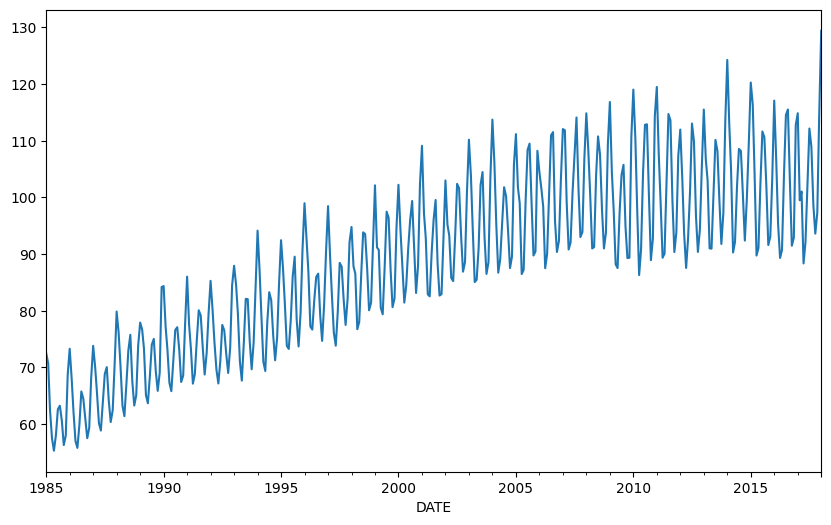

In [80]:
# Vamos dar uma olhada no gráfico de consumo x anos
df['producao'].plot(figsize=(10,6))

Análise de Sazonalidade - 

quando os fenômenos que ocorrem durante o tempo se repetem a cada período idêntico de tempo

<AxesSubplot: xlabel='DATE'>

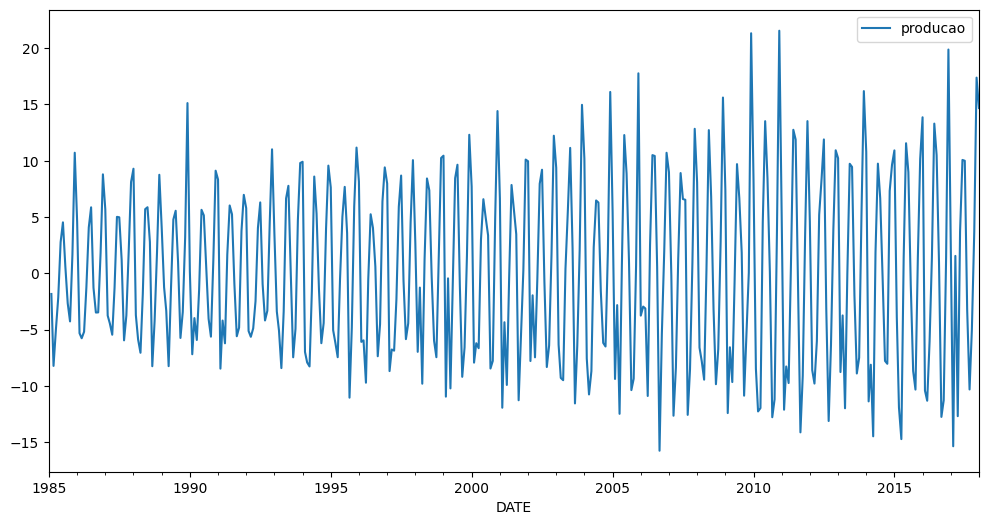

In [81]:
df.diff().plot(figsize=(12,6))

<AxesSubplot: xlabel='DATE'>

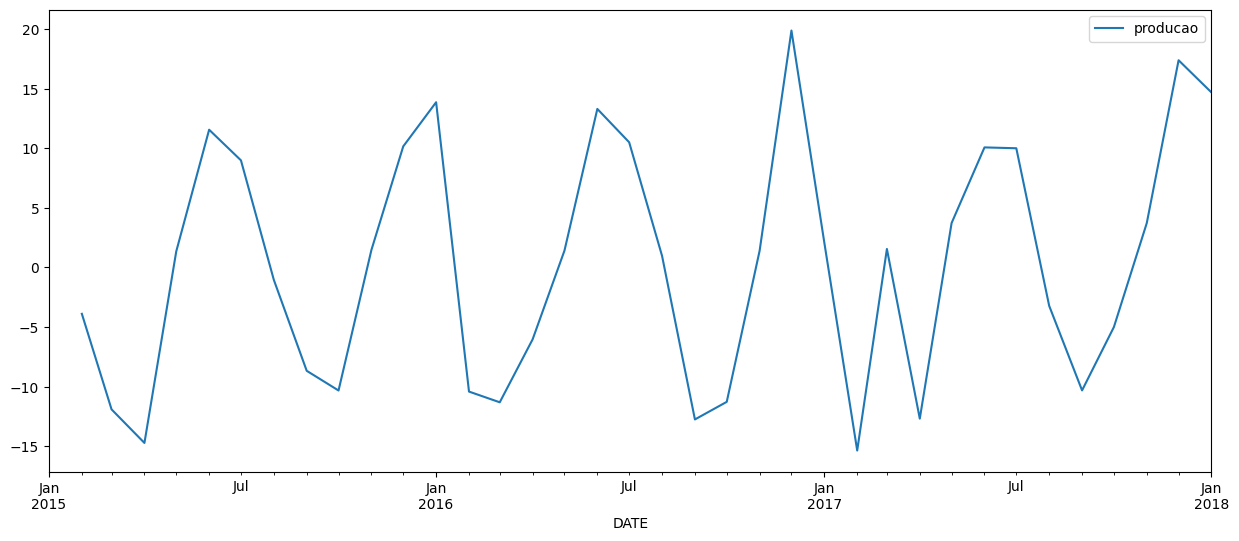

In [82]:
filtro = (df.index.year >= 2010) & (df.index.year >= 2015)
df[filtro].diff().plot(figsize=(15,6))

Análise de Tendência

é definida como um padrão de crescimento/descrecimento da variável em um certo período de tempo

<AxesSubplot: xlabel='DATE'>

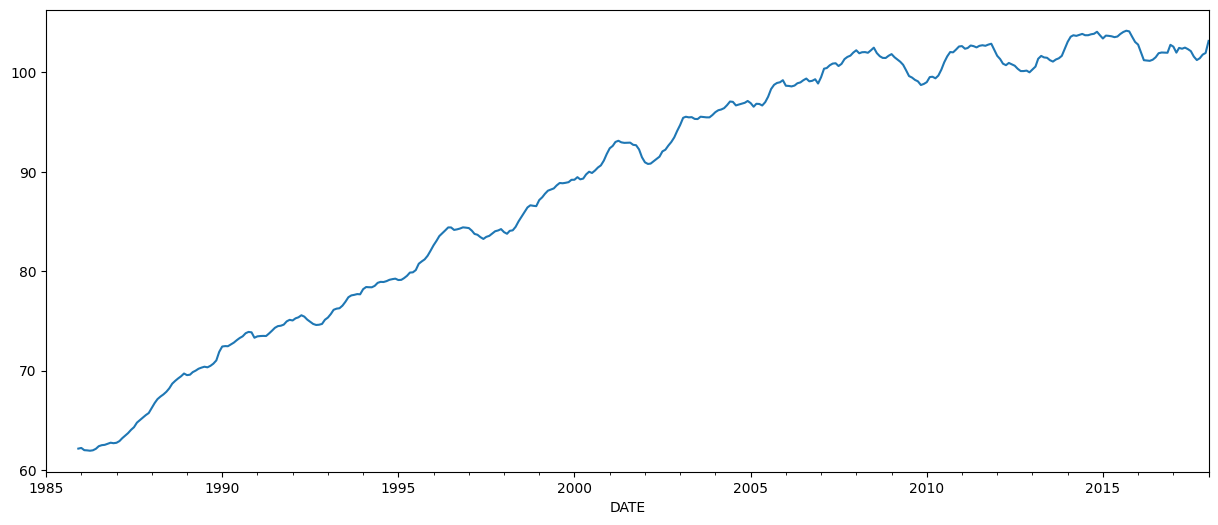

In [83]:
df.producao.rolling(12).mean().plot(figsize=(15,6))

Verificando se a série é estacionaria

Para que o modelo apresente resultados aceitáveis, é necessário que sejam previamente definidos os parâmetros de cada um dos componentes do modelo ARIMA. Eles dependem do comportamento da série temporal a qual está sendo estudada e, através dela, podem ser determinados com o auxílio do teste de Dickey-Fuller aumentado (ADF) e das funções de autocorrelação (ACF) e autocorrelação parcial

Para que o ARIMA possa ser aplicado à determinada série temporal, é necessário que seja estacionária. Caso não haja taxa de crescimento significativa, a série pode ser considerada estacionária (e caso haja, deve-se diferenciá-la a fim de atingir um estado de estacionaridade).

Se o resultado do ADF for menor do que o valor critico para um determinado percentual (5% no nosso caso) e o p-value for significante (menor que 0.05), a série é considerada estacionária. Do contrário a série é não estacionária

In [84]:
from statsmodels.tsa.stattools import adfuller   

result = adfuller(df.producao) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')   

for key, value in result[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.256990
p-value: 0.186215
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [85]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

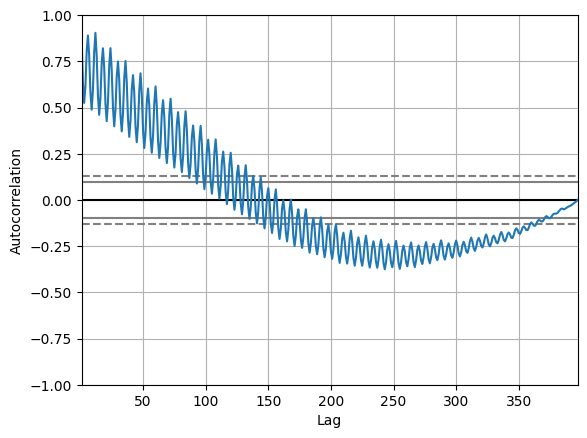

In [86]:
from pandas.plotting import autocorrelation_plot
# autocorrelation plot 
autocorrelation_plot(df)
pyplot.show()

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


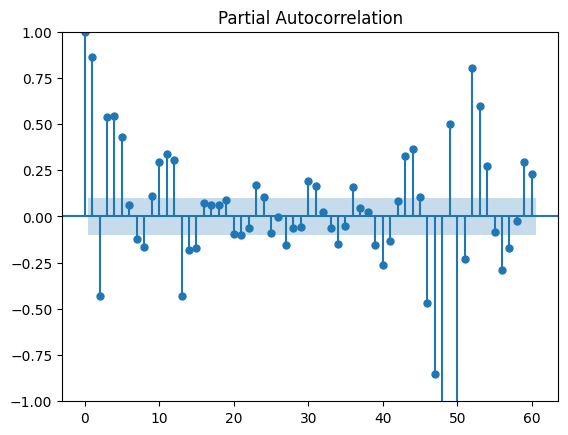

In [87]:
plot_pacf(df, lags=60)
pyplot.show()

Modelo ARIMA -

Método estatístico que utiliza autoregressão e médias móveis para previsão de séries temporais. Um modelo linear é construído incluindo um número especificado de termos e os dados são preparados por um nível de diferenciação afim de tornar este estacionário.

Podemos usar um valor 0 para desligar um parâmetro, dessa forma, aquela função em questão não será feita, por exemplo, se no parâmetro d definirmos 0 não será realizada uma diferenciação nos dados.

In [88]:
# ARIMA(p,d,q)
model = ARIMA(df, order=(7,1,1))

In [89]:
model_fit = model.fit()

In [90]:
# plot residuais
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)

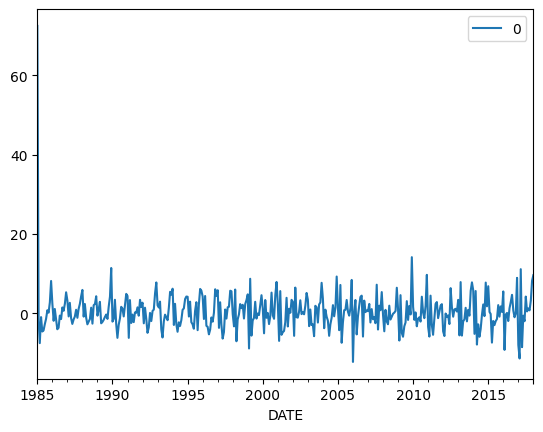

In [91]:
residuals.plot()
pyplot.show()

Prevendo dados com ARIMA utilizando Walk Forward

O modelo arima contém alguns parâmetros

ARIMA(p,d,q)
    p: O número de lags que foram devem ser incluídos no modelo.
    d: O número de vezes que as observações serão diferenciadas.
    q: O tamanho de uma janela de média móvel. Também chamada de ordem de média móvel.

Separando dados treino e teste

In [92]:
# a variável X recebe os dados da série
X = df.values
X = X.astype('float32')

In [93]:
# Separa os dados com 50% dos dados para treino e 50% dos dados para teste
size = int(len(X) * 0.50)

In [94]:
# Separa dados de treino e teste
train = X[0:size]
test =  X[size:]

In [95]:
# cria a variável history, variavel de controle para o walk foward
history = [x for x in train]

In [96]:
# cria lista de previsões
predictions = list()

In [101]:
# Cria a função que faz a diferenciação - pega o valor do mes atual e subtrai com o mesmo mês do ano anterior, essa
# diferença vai ser o dataset diferenciado
def difference(dataset, interval=1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval=1):
  return previsao + history[-interval]

In [103]:
# inicia Walk-Forward
for t in range(len(test)):
  
  # difference data
  meses_no_ano = 12
  diff = difference(history, meses_no_ano)
  
  # cria um modelo ARIMA com os dados de history p q e d
  model = ARIMA(diff, order=(1,0,1)) # p = vai usar o mes anterior como lag, d = medias movel nivel 1
  
  # treina o modelo ARIMA
  model_fit = model.fit()
  
  # a variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]

  # valor_predito recebe o valor revertido (escala original)
  valor_predito = inverse_difference(history, valor_predito, meses_no_ano)
   
  # adiciona o valor predito na lista de predicões
  predictions.append(valor_predito)
  
  # a variável valor_real recebe o valor real do teste
  valor_real = test[t]
  
  # adiciona o valor real a variável history
  history.append(valor_real)

  # imprime valor predito e valor real
  print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=108.382, Valor esperado= 96
Valor predito=98.160, Valor esperado=100
Valor predito=88.454, Valor esperado= 88
Valor predito=92.518, Valor esperado= 83
Valor predito=97.257, Valor esperado= 83
Valor predito=102.294, Valor esperado= 93
Valor predito=99.608, Valor esperado=103
Valor predito=97.148, Valor esperado= 95
Valor predito=92.267, Valor esperado= 93
Valor predito=97.771, Valor esperado= 86
Valor predito=108.223, Valor esperado= 85
Valor predito=112.617, Valor esperado= 93
Valor predito=75.310, Valor esperado=102
Valor predito=108.888, Valor esperado=102
Valor predito=88.004, Valor esperado= 93
Valor predito=86.086, Valor esperado= 87
Valor predito=85.140, Valor esperado= 89
Valor predito=96.365, Valor esperado=101
Valor predito=107.393, Valor esperado=110
Valor predito=99.057, Valor esperado=104
Valor predito=98.121, Valor esperado= 95
Valor predito=86.007, Valor esperado= 85
Valor predito=85.143, Valor esperado= 85
Valor predito=93.740, Valor esperado= 91
Valor pred

In [100]:
# Avaliando os resultados
# calcula "a raiz quadrática média" dos erros entre valores observados (reais) e predições (hipóteses)
from numpy import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.487


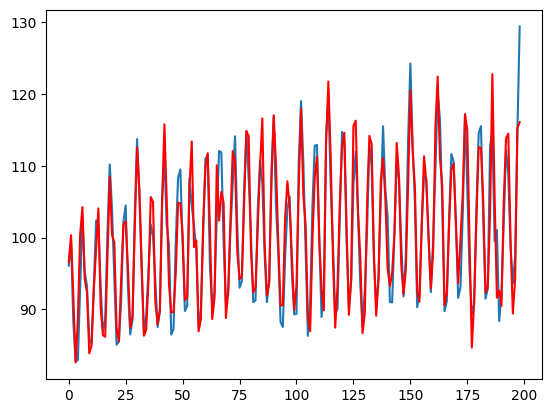

In [99]:
# plot forecasts against actual outcomes 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()